
# ID Card Scan → Rectify → OCR Comparisons

This notebook walks through:

1. Load & downscale the image  
2. Grayscale → Blur → Canny edges  
3. Contour detection → choose the 4-point card  
4. Perspective warp (top-down)  
5. Crop ROIs (photo, name, address, ID)  
6. OCR comparisons:
   - Tesseract `ara`
   - Tesseract `ara_number`
   - Tesseract `ara+eng` with digit whitelist
   - EasyOCR (if installed)
   - PaddleOCR (if installed)

> **Note:** Configure the input path and Tesseract paths in the **User Settings** cell.


In [ ]:
# 📦 SETUP CELL — run this ONCE to install all required libraries
# After running successfully, you don't need to run it again unless you reset the environment.
!pip install -q numpy opencv-python matplotlib imutils scikit-image
!pip install -q pytesseract easyocr "paddleocr>=2.6.0.1" "paddlepaddle>=2.5.0"
!pip install -q python-doctr[torch]  # optional: DocTR OCR (deep learning)
!pip install -q pandas nbformat
!pip install -q imutils

  Using cached paddleocr-3.2.0-py3-none-any.whl.metadata (29 kB)
  Using cached paddlepaddle-3.1.1-cp313-cp313-win_amd64.whl.metadata (8.7 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached protobuf-6.32.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached chardet-5.2.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached prettytable-3.16.0-py3-none-any.whl.metadata (33 kB)
  Using cached ruamel.yaml-0.18.15-py3-none-any.whl.metadata (25 kB)
  Using cached ujson-5.11.0-cp313-cp313-win_amd64.whl.metadata (9.6 kB)
  Using cached imagesize-1.4.1-py2.py3-none-any.whl.metadata (1.5 kB)
  Using cached opencv_contrib_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached pypdfium2-4.30.0-py3-none-win_amd64.whl.metadata (48 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached ruam

  You can safely remove it manually.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:

# ==== USER SETTINGS ====
# Set your image path here (front photo of the ID card). Example:
# INPUT_PATH = r"E:\projects\arabic_ocr\ocr-arabic-master\temp_front.jpg"
path = "marwanfront.jpg"

# Optional: configure Tesseract (Windows example)
TESSERACT_EXE = r"E:\CS-Programmes\tesseract.exe"  # change if needed
TESSDATA_DIR  = r"E:\CS-Programmes\tessdata"       # directory containing *.traineddata

# Target height when processing (speed) and final display size after warp
working_height = 500
FINAL_SIZE = (1000, 630)  # (width, height)
TARGET_AR = 1.58                 # expected ID aspect ratio (W/H)
AREA_MIN_FRAC = 0.05             # 5% of frame
AREA_MAX_FRAC = 0.65             # 65% of frame
TOPK_CANDIDATES = 6              # how many boxes to OCR re-rank

In [18]:
# ==== IMPORTS & SETUP ====
import os, sys, math, json, textwrap, traceback
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re
from pytesseract import image_to_string
import imutils

In [4]:
# Inline plots
%matplotlib inline

# OCR availability checks
TESSERACT_AVAILABLE = False
try:
    import pytesseract
    if Path(TESSERACT_EXE).exists():
        pytesseract.pytesseract.tesseract_cmd = TESSERACT_EXE
    if Path(TESSDATA_DIR).exists():
        os.environ["TESSDATA_PREFIX"] = TESSDATA_DIR
    _ = pytesseract.get_tesseract_version()
    TESSERACT_AVAILABLE = True
except Exception as e:
    print("Tesseract not available:", e)

EASYOCR_AVAILABLE = False
try:
    import easyocr  # pip install easyocr
    EASYOCR_AVAILABLE = True
except Exception as e:
    print("EasyOCR not available:", e)

PADDLE_AVAILABLE = False
try:
    from paddleocr import PaddleOCR  # pip install 'paddleocr>=2.6.0.1'
    PADDLE_AVAILABLE = True
except Exception as e:
    print("PaddleOCR not available:", e)

print("OCR engines availability:")
print(" - Tesseract :", TESSERACT_AVAILABLE)
print(" - EasyOCR   :", EASYOCR_AVAILABLE)
print(" - PaddleOCR :", PADDLE_AVAILABLE)


OCR engines availability:
 - Tesseract : True
 - EasyOCR   : True
 - PaddleOCR : True


In [5]:

# ==== GEOMETRY HELPERS (from your code) ====
def order_points(pts):
    import numpy as np
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right
    diff = np.diff(pts, axis=1)  # (y - x)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA  = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB  = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxW = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxH = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxW - 1, 0],
        [maxW - 1, maxH - 1],
        [0, maxH - 1]], dtype="float32"
    )

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(
        image, M, (maxW, maxH),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_REPLICATE
    )
    return warped


In [6]:
def normalize_digits(txt: str) -> str:
    # Arabic-Indic & Eastern Arabic-Indic → ASCII
    trans = str.maketrans("٠١٢٣٤٥٦٧٨٩۰۱۲۳۴۵۶۷۸۹", "01234567890123456789")
    return txt.translate(trans)

In [86]:
# -- Helper: try to read a long-enough ID candidate from a finalized card image --
def _has_long_id_candidate(final_img):
    """
    1) Gray → OTSU binarize
    2) Crop ID ROI [480:560, 400:1000]
    3) Tesseract 'ara_number' → keep digits only (normalize Arabic digits)
    Return: (True/False, digits_string)
    """

    # gray + OTSU
    im_gray = cv2.cvtColor(final_img, cv2.COLOR_BGR2GRAY)
    im_bw = im_gray
    thresh = 90
    im_bw = cv2.threshold(im_bw, thresh, 255, cv2.THRESH_BINARY)[1]

    # ROI (same indices you gave)
    ID = im_bw[480:560, 400:1000]

    # OCR (ara_number). If not installed, you can swap to 'ara+eng' + whitelist.
    try:
        raw = image_to_string(ID, lang="ara_number")
    except Exception:
        raw = image_to_string(
            ID, lang="ara+eng",
            config="--psm 7 -c tessedit_char_whitelist=0123456789٠١٢٣٤٥٦٧٨٩۰۱۲۳۴۵۶۷۸۹"
        )

    # normalize Arabic/Eastern Arabic digits → ASCII and keep digits only
    trans = str.maketrans("٠١٢٣٤٥٦٧٨٩۰۱۲۳۴۵۶۷۸۹", "01234567890123456789")
    digits = "".join(ch for ch in raw.translate(trans) if ch.isdigit())

    return (len(digits) >= 12), digits


# -- Helper: validation score for Egyptian ID (heuristic you specified) --
def _egypt_id_score(idnum: str) -> float:
    """
    Heuristic score [0..1] for Egyptian national ID:
    - 14 digits
    - index 0 in {'2','3'} (century)
    - MM in 01..12, DD in 01..31
    - gov code (index 7..9) in known list
    """
    if not idnum or not idnum.isdigit():
        return 0.0

    score = 0.0

    # length check (not in your weights; optional tiny nudge if 14 digits)
    if len(idnum) == 14:
        score += 0.0  # keep weights exactly as you gave

    # century
    century_ok = (len(idnum) >= 1 and idnum[0] in ("2", "3"))
    if century_ok:
        score += 0.10

    # month/day (guard against short strings)
    mm_ok = False
    dd_ok = False
    if len(idnum) >= 7 and idnum[3:5].isdigit() and idnum[5:7].isdigit():
        mm = int(idnum[3:5]); dd = int(idnum[5:7])
        mm_ok = (1 <= mm <= 12)
        dd_ok = (1 <= dd <= 31)
    if mm_ok: score += 0.35
    if dd_ok: score += 0.35

    # governorate code
    gov_ok = False
    if len(idnum) >= 9:
        valid_govs = {
            "01","02","03","04","11","12","13","14","15","16",
            "17","18","19","21","22","23","24","25","26","27",
            "28","29","31","32","33","34","35","88"
        }
        gov_ok = idnum[7:9] in valid_govs
    if gov_ok: score += 0.20

    return min(score, 1.0)


In [77]:
# ---------- tiny local helper to show images (won't crash if plt missing) ----------
def _show(title, img):
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6,6))
        plt.title(title)
        if img is None:
            plt.text(0.5, 0.5, "None", ha="center", va="center")
            plt.axis("off"); plt.show(); return
        if img.ndim == 2:
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()
    except Exception:
        # fallback: do nothing if matplotlib/GUI not available
        pass

In [78]:
# ---------- 1) load & resize ----------
def _load_and_resize(pth, h=working_height):
    img0 = cv2.imread(pth)
    if img0 is None:
        raise FileNotFoundError(f"Could not read image at: {pth}")
    H, W = img0.shape[:2]
    ratio = H / float(h)
    new_w = int(round(W / ratio))
    img_resized = cv2.resize(img0, (new_w, h), interpolation=cv2.INTER_AREA)
    return img0.copy(), img_resized, ratio

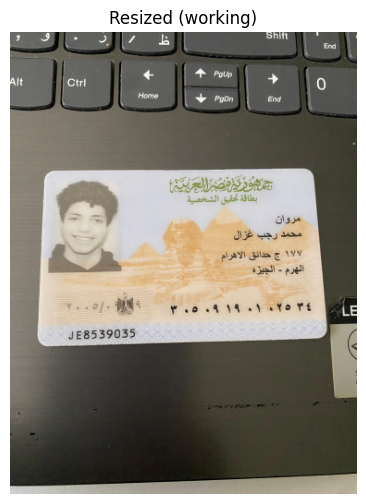

In [79]:
orig, image, ratio = _load_and_resize(path, h=working_height)
_show("Resized (working)", image)

In [80]:
# ---------- 2) preprocess to edges ----------
def _preprocess_to_edges(img_resized):
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
    v = np.median(gray_blur)
    lower = int(max(0, 0.66 * v))
    upper = int(min(255, 1.33 * v))
    edged = cv2.Canny(gray_blur, lower, upper)
    return gray, edged

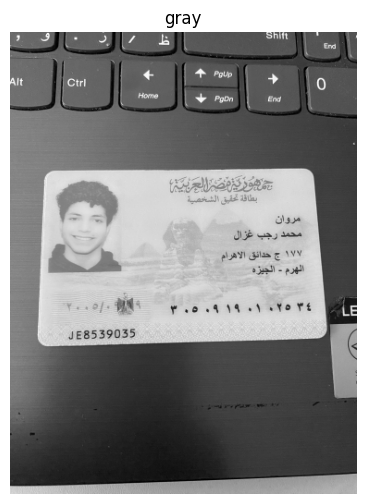

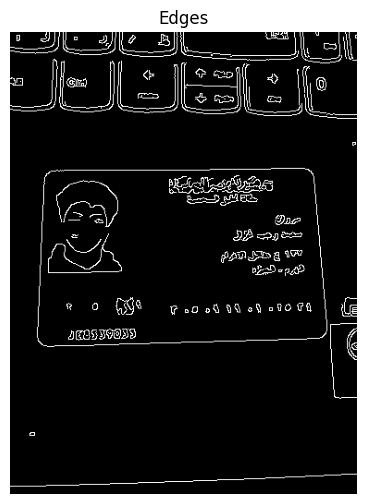

In [81]:
gray, edged = _preprocess_to_edges(image)
_show("gray", gray)
_show("Edges", edged)

In [102]:
# ---------- 3) collect rectangle candidates via minAreaRect ----------
def _collect_candidates(edged, img_resized, orig, ratio):
    # find the contours in the edged image, keeping only the
    # largest ones, and initialize the screen contour
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
    # loop over the contours
    screenCnt = None         # quad that passes the 12+ digits check
    first_quad = None        # fallback: first quad encountered

    for c in cnts:
            # approximate the contour
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)

            # if our approximated contour has four points, then we
            # can assume that we have found our screen
            if len(approx) == 4:
                # --- NEW: finalize this quad to a normalized card image ---
                # If you already have _finalize(best_box, image, orig, ratio) use it:
                if first_quad is None:
                    first_quad = approx
                try:
                    # approx is in resized coords already; _finalize expects a 4x2 box
                    vis_quad_tmp, warped_tmp, final_tmp = _finalize(approx.reshape(4, 2), image, orig, ratio)
                    final = final_tmp
                except NameError:
                    # fallback: same as your original finalize: warp + resize
                    warped_tmp = four_point_transform(orig, approx.reshape(4, 2) * ratio)
                    final = cv2.resize(warped_tmp, (1000, 630), interpolation=cv2.INTER_LINEAR)

                # --- NEW: OCR quick-check → require >= 12 digits in the ID strip ---
                is_long_enough, id_digits = _has_long_id_candidate(final)

                # --- NEW: compute & print the validation score for feedback ---
                val_score = _egypt_id_score(id_digits)
                print(f"[ID check] digits='{id_digits}' len={len(id_digits)} | validation_score={val_score:.2f}")

                if is_long_enough:
                    screenCnt = approx
                    # we NOW break only if OCR found >=12 digits (your new condition)
                    break
                # else: keep scanning other quadrilaterals
    # fallback if nothing passed OCR
    if screenCnt is None and first_quad is not None:
        screenCnt = first_quad

    if screenCnt is None:
        raise RuntimeError("No suitable quadrilateral found to warp.")
        
    # apply the four point transform to obtain a top-down
    # view of the original image
    warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

    # show the original and scanned images
    best_box = screenCnt.reshape(4, 2).astype("float32")
    newimg = cv2.resize(warped,(1000,630))
    cv2.imwrite("temp_front.jpg",newimg)  
    return newimg,first_quad.reshape(4, 2)


[ID check] digits='30509190102534' len=14 | validation_score=1.00


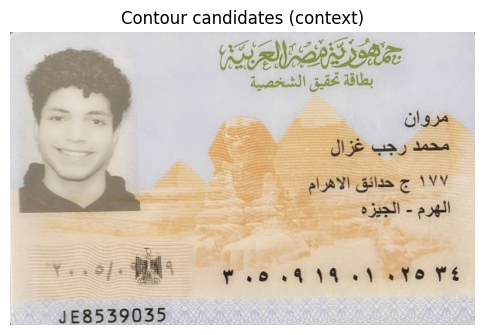

In [104]:
newimg , best_box= _collect_candidates(edged, image, orig, ratio)
_show("Contour candidates (context)", newimg)

In [112]:
# ---------- 5) finalize drawing + warp final ----------
def _finalize(best_box, img_resized, orig, ratio):
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    vis_quad = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    if best_box is None:
        return vis_quad, None, None

    cv2.drawContours(vis_quad, [best_box.astype(int)], -1, (255, 0, 0), 3)
    warped = four_point_transform(orig, best_box.reshape(4, 2) * ratio)
    final  = cv2.resize(warped, FINAL_SIZE, interpolation=cv2.INTER_LINEAR)
    return vis_quad, warped, final

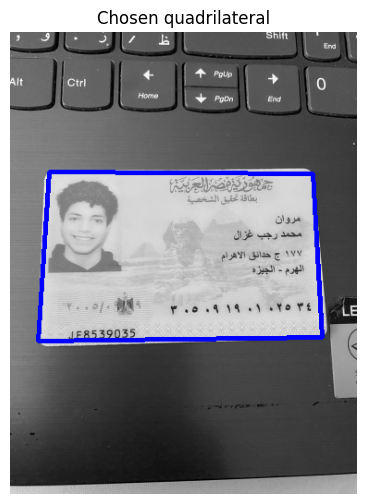

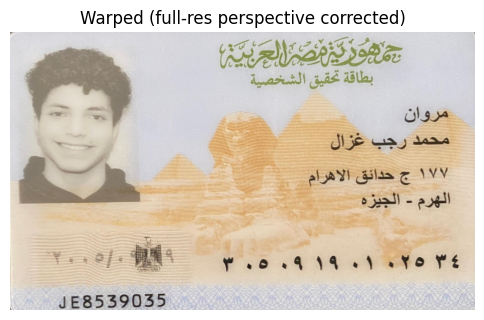

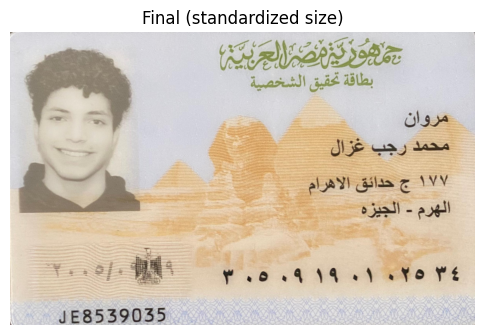

In [113]:
vis_quad, warped, final = _finalize(best_box, image, orig, ratio)
_show("Chosen quadrilateral", vis_quad)
_show("Warped (full-res perspective corrected)", warped)
_show("Final (standardized size)", final)

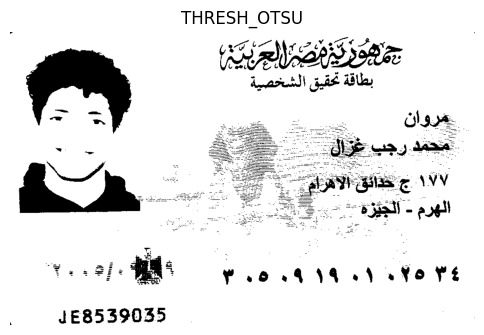

In [115]:
im_bw_OTSU = im_gray
im_bw_OTSU = cv2.threshold(im_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
_show("THRESH_OTSU", im_bw_OTSU)

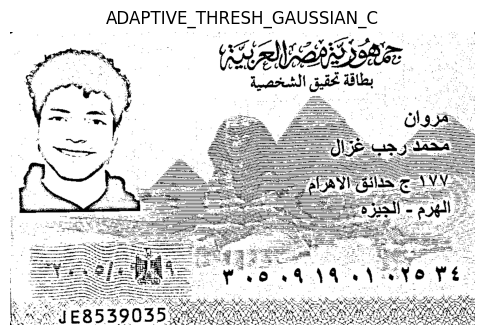

In [91]:
im_bw_GAUSSIAN = im_gray
im_bw_GAUSSIAN = cv2.adaptiveThreshold(
    im_gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    35,   # blockSize
    10    # C
)
_show("ADAPTIVE_THRESH_GAUSSIAN_C", im_bw_GAUSSIAN)

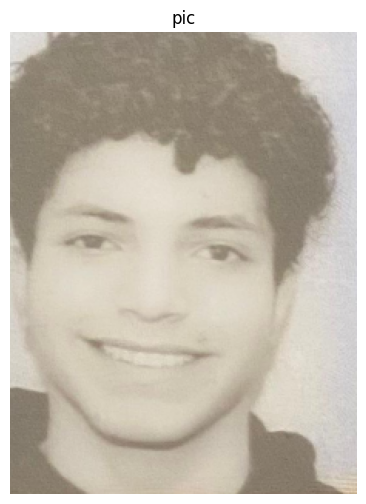

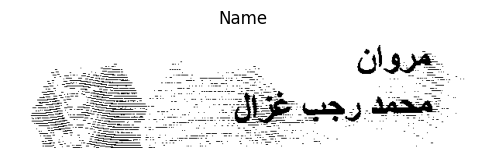

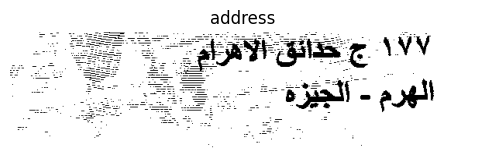

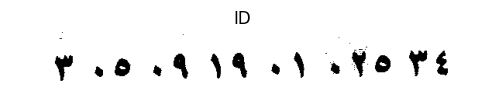

In [69]:
pic = newimg[50:350,50:275]
Name = im_bw_OTSU[150:300, 400:1000]
address = im_bw_OTSU[300:450, 400:1000]
ID = im_bw_OTSU[480:560,400:1000]
_show("pic", pic)
_show("Name", Name)
_show("address", address)
_show("ID", ID)

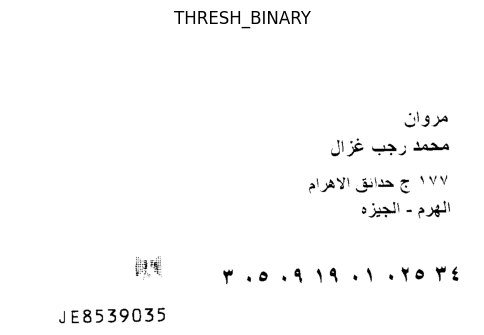

In [ ]:
im_gray = cv2.cvtColor(newimg, cv2.COLOR_BGR2GRAY)
im_bw = im_gray
thresh = 90
im_bw = cv2.threshold(im_bw, thresh, 255, cv2.THRESH_BINARY)[1]
_show("THRESH_BINARY", im_bw)


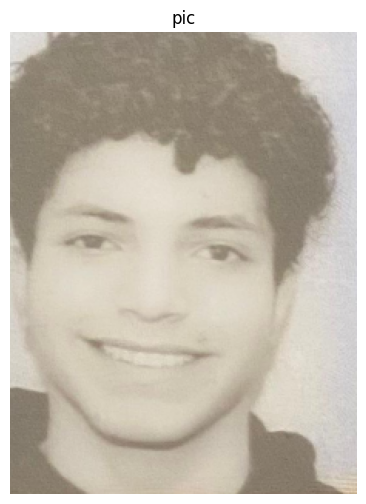

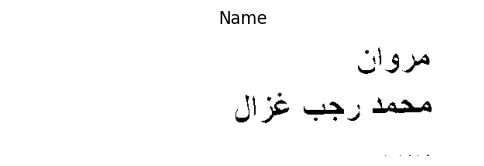

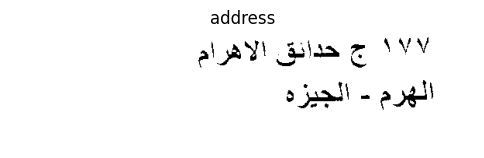

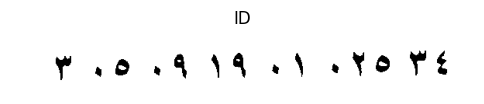

In [163]:
pic = newimg[50:350,50:275]
Name = im_bw[150:310, 400:1000]
address = im_bw[300:450, 400:1000]
ID = im_bw[480:560,400:1000]
_show("pic", pic)
_show("Name", Name)
_show("address", address)
_show("ID", ID)

In [164]:
from pytesseract import image_to_string
name=image_to_string(Name,lang="ara")
add=image_to_string(address,lang="ara")
IDNumber=image_to_string(ID,lang="ara")
print(IDNumber , name , add)

‎١1١١ ١‏ 4 هم
 مروان
محمد رجب غزال
 لالج حدانة نق الاهرام

الهرم - الجيزه



In [165]:
name=image_to_string(Name,lang="ara")
add=image_to_string(address,lang="ara_combined")
IDNumber=image_to_string(ID,lang="ara_number")
print(IDNumber , name , add)

3050919 0102534
 مروان
محمد رجب غزال
 ۷ ج حدانۇ نق الاهرام

الهرم - الجيزه



In [150]:
# --- EASYOCR ---
import easyocr

# 1) Init reader (Arabic + English). Set gpu=True if you have CUDA configured.
_reader = easyocr.Reader(['ar', 'en'], gpu=False)

def _to_gray(img):
    if img is None:
        return None
    if len(img.shape) == 2:  # already gray
        return img
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def _normalize_digits(s: str) -> str:
    trans = str.maketrans("٠١٢٣٤٥٦٧٨٩۰۱۲۳۴۵۶۷۸۹", "01234567890123456789")
    return "".join(ch for ch in s.translate(trans) if ch.isdigit())

# 2) NAME & ADDRESS (plain OCR, no allowlist)
#    detail=0 returns just strings; paragraph=True merges nearby lines
_name_lines = _reader.readtext(Name,    detail=0, paragraph=True) if Name is not None else []
_add_lines  = _reader.readtext(address, detail=0, paragraph=True) if address is not None else []

name = "\n".join(_name_lines).strip() if _name_lines else ""
add  = "\n".join(_add_lines).strip()   if _add_lines  else ""

# 3) ID (digits) — preprocess the ROI to help detection and restrict to digits
if ID is None:
    IDNumber = ""
else:
    _id_gray = _to_gray(ID)
    # OTSU binarization for contrast
    _id_bin  = cv2.threshold(_id_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Upscale and slightly close gaps (thicken strokes)
    _id_big = cv2.resize(_id_bin, None, fx=2.5, fy=2.5, interpolation=cv2.INTER_CUBIC)
    _kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    _id_big = cv2.morphologyEx(_id_big, cv2.MORPH_CLOSE, _kernel, iterations=1)

    # Restrict to digits (Arabic/Eastern/ASCII)
    _allow_digits = '0123456789٠١٢٣٤٥٦٧٨٩۰۱۲۳۴۵۶۷۸۹'
    _res_id = _reader.readtext(_id_big, detail=1, paragraph=False, allowlist=_allow_digits)

    # Merge detected pieces left→right
    _pieces = []
    for det in _res_id:
        # EasyOCR (detail=1) usually returns: (bbox, text, conf)
        # but be defensive in case of variant shapes
        if isinstance(det, (list, tuple)) and len(det) >= 2:
            bbox = det[0]
            text = det[1] if len(det) >= 2 else ""
            # conf = det[2] if len(det) >= 3 else None  # available if you need it

            # bbox is a list of 4 points [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
            try:
                x_min = min(p[0] for p in bbox)
            except Exception:
                # fallback if bbox is unexpected
                x_min = 0
            _pieces.append((x_min, str(text)))
        elif isinstance(det, str):
            # Unexpected: sometimes detail=0-like element slips in
            _pieces.append((0, det))

    _pieces.sort(key=lambda t: t[0])
    _id_text = "".join(t for _, t in _pieces)
    IDNumber = _normalize_digits(_id_text)

# 4) Print like your Tesseract block (you can keep or remove this)
print(IDNumber, '\n',name, '\n', add)

[2025-09-03 12:00:10,678] [ WARNING] easyocr.py:71 - Using CPU. Note: This module is much faster with a GPU.
c:\Users\gasse\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


0919002534 
 مروان محمد رجب غزال 
 ١٧٧ ج حدائق الاهرام الهرم الجيز


In [ ]:
# --- PADDLEOCR (Arabic) | direct extraction, no preprocessing ---
from paddleocr import PaddleOCR
import numpy as np
import cv2

ocr = PaddleOCR(lang='ar', use_angle_cls=True)

def to_bgr3(img):
    """Ensure HxWx3 np.uint8 (Paddle needs 3 channels)."""
    if img is None:
        return None
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    elif img.ndim == 3 and img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img

def run_flat_text(img):
    """Run Paddle (predict if available else ocr) and return list of texts only."""
    if img is None:
        return []
    img = to_bgr3(img)
    # Try predict() then fallback to ocr()
    try:
        res = ocr.predict(img) if hasattr(ocr, "predict") else ocr.ocr(img)
    except Exception:
        res = ocr.ocr(img)

    lines = []
    for page in (res or []):
        for det in (page or []):
            # Old style: [poly, (text, conf)]
            if isinstance(det, (list, tuple)) and len(det) >= 2:
                rec = det[1]
                if isinstance(rec, (list, tuple)) and rec:
                    t = rec[0]
                elif isinstance(rec, dict):
                    t = rec.get("text") or rec.get("rec_text") or ""
                else:
                    t = ""
                if t: lines.append(str(t))
            # New dict style
            elif isinstance(det, dict):
                t = det.get("text") or det.get("rec_text") or det.get("label") or ""
                if t: lines.append(str(t))
    return [t for t in lines if t.strip()]

def normalize_digits(s: str) -> str:
    trans = str.maketrans("٠١٢٣٤٥٦٧٨٩۰۱۲۳۴۵۶۷۸۹", "01234567890123456789")
    return "".join(ch for ch in s.translate(trans) if ch.isdigit())

# ---- Run directly on your ROIs (NO preprocessing) ----
name_lines = run_flat_text(Name)
add_lines  = run_flat_text(address)
id_lines   = run_flat_text(ID)

# Join simply with spaces (so الكلمات ما تلزقش)
name = " ".join(name_lines).strip()
add  = " ".join(add_lines).strip()
IDNumber = normalize_digits(" ".join(id_lines))

print(IDNumber, "\n", name, "\n", add)


C:\Users\gasse\AppData\Local\Temp\ipykernel_1760\3026378368.py:6: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr = PaddleOCR(lang='ar', use_angle_cls=True)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\gasse\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\gasse\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\gasse\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv3_mobile_det', None)
Model files already exist. Using cached files. To redownload, please d